IMPORT LIBRARY

In [1]:
from __future__ import print_function
import keras, pickle
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import LSTM, AveragePooling2D, Input,UpSampling2D ,Conv2DTranspose,GlobalAveragePooling2D,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.layers.core import Lambda
K.set_learning_phase(1)
import os,random
import numpy as np
os.environ["KERAS_BACKEND"] = "tensorflow"
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,Lambda,Permute
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.callbacks import TensorBoard, EarlyStopping
import pickle, random, time
from keras import layers
import tensorflow_addons as tfa
from keras import metrics, regularizers, optimizers, backend
from tensorflow.keras.models import load_model


C:\Users\totru\anaconda3\envs\tf-2.0\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


IMPORT DATASET

In [2]:
with open("RML2016.10a_dict.pkl",'rb') as file:
    Xd = pickle.load(file,encoding='bytes')
    

DATA PROCESSING

In [3]:
test_snrs,mods = map(lambda j: sorted( list( set( map( lambda x: x[j], Xd.keys() ) ) ) ), [1,0])
X = []
lbl = []

for mod in mods:
    for snr in test_snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
print(X.shape)

(220000, 2, 128)


In [4]:
np.random.seed(2019)
n_examples = X.shape[0]
n_train    = int(round(n_examples * 0.8))
train_idx  = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx   = list(set(range(0,n_examples))-set(train_idx))
X_train    = X[train_idx]
X_test     = X[test_idx]

def to_onehot(yy):
    yy1 = np.zeros([len(yy) ,max(yy)+1])
    yy1[  np.arange(len(yy)),yy] = 1 # ?
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
input_shape = (in_shp[0],in_shp[1],1)
print(X_train.shape, in_shp,input_shape)
classes = ["8PSK", 'AM-DSB','AM-SSB','BPSK', 'CPFSK','GFSK','PAM4', 'QAM16', 'QAM64','QPSK','WBFM']

(176000, 2, 128) [2, 128] (2, 128, 1)


BULD MODEL

In [5]:
#ResNet class
def ResNet_Block(net,Filters,Seq):
    net = Conv2D(Filters, (2, 3), padding='same', kernel_initializer='glorot_uniform',data_format="channels_first")(net)
    net = BatchNormalization(axis = 3)(net)
    #ResNet_Block 1
    net_shortcut = net
    net = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_uniform',data_format="channels_first")(net)
    net = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform',data_format="channels_first")(net)
    net = layers.add([net,net_shortcut])
    net = Activation("relu")(net)
    #ResNet_Block 2
    net_shortcut = net
    net = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_uniform',data_format="channels_first")(net)
    net = Conv2D(Filters, (3, 2),padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform',data_format="channels_first")(net)
    net = BatchNormalization(axis = 3)(net)
    net = layers.add([net,net_shortcut])
    net = Activation("relu")(net)
    return net

In [6]:
def abs_backend(inputs):
    return K.abs(inputs)

def expand_dim_backend(inputs):
    return K.expand_dims(K.expand_dims(inputs,1),1)

def sign_backend(inputs):
    return K.sign(inputs)
# Define the linear combination
def LC(x):
        import keras.backend as K
        y = K.constant([0, 1, 0, -1, 0, 1],shape=[2,3])
        return K.dot(x,K.transpose(y))
   

In [7]:
#TAD denoiser
def auto_coder_denoise(incoming, per):
    _in_ = incoming
    identity = incoming
    #ENCODER
    encoder = BatchNormalization()(_in_ )
    encoder = Conv2D(filters=64, kernel_size=(2,3), strides=1, padding='same', kernel_initializer='glorot_uniform', activation='relu')(encoder)
    encoder = Conv2D(filters=16, kernel_size=(2,3), strides=1, padding='same',  kernel_initializer='glorot_uniform')(encoder)
    # Calculate global means
    residual_abs = Lambda(abs_backend)(encoder)
    abs_mean = GlobalAveragePooling2D()(residual_abs)
        
    # Calculate scaling coefficients
    scales = Dense(16, activation=None, kernel_initializer='he_normal', 
                       kernel_regularizer=l2(1e-4))(abs_mean)
    scales = BatchNormalization()(scales)
    scales = Activation('relu')(scales)
    scales = Dense(16, activation='sigmoid', kernel_regularizer=l2(1e-4))(scales)
    scales = Lambda(expand_dim_backend)(scales)
        
    # Calculate thresholds
    thres = keras.layers.multiply([abs_mean, scales]) + (per * keras.layers.multiply([abs_mean, scales]))
        
    # denoise 
    sub = keras.layers.subtract([residual_abs, thres])
    zeros = keras.layers.subtract([sub, sub])
    n_sub = keras.layers.maximum([sub, zeros])
    residual = keras.layers.multiply([Lambda(sign_backend)(encoder), n_sub])
    # DECODER
    decoder = Conv2D(filters=16, kernel_size=(2,3), strides=1, padding='same',  kernel_initializer='glorot_uniform', activation='relu')(residual)
    decoder = Conv2D(filters=64, kernel_size=(2,3), strides=1, padding='same',  kernel_initializer='glorot_uniform')(decoder)
    output = Conv2D(filters=1, kernel_size=(2,3), strides=1, padding='same',  kernel_initializer='glorot_uniform')(decoder)
    return output 

In [8]:
inputs = Input(shape=input_shape)
X = auto_coder_denoise(inputs, 1)
X = Reshape([1]+in_shp, input_shape=in_shp)(X)
X = ZeroPadding2D((1,2), data_format='channels_first')(X)
X = Conv2D(80, (2,3), padding='valid', activation='relu', name="conv1", kernel_initializer='glorot_uniform', data_format='channels_first')(X)
X = Permute((1,3,2))(X)
X = Lambda(LC)(X)
X = Permute((1,3,2))(X)
X = Activation('relu')(X)
X = ResNet_Block(X,32,"Block1")  #shape:(1,512,32)
X = MaxPooling2D(pool_size=(1, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
X = ResNet_Block(X,32,"Block2")
X = MaxPooling2D(pool_size=(1, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
X = ResNet_Block(X,32,"Block3")
X = Flatten()(X)
X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
#Full Con 2
X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
X = AlphaDropout(0.2)(X)
# #Full Con 3
X = Dense(len(classes), kernel_initializer='he_normal', name="dense3")(X)
#SoftMax
X = Activation('softmax')(X)
model_proposal = Model(inputs=inputs, outputs=X )

adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_proposal.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model_proposal.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 128, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 2, 128, 1)   4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 2, 128, 64)   448         ['batch_normalization[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 2, 128, 16)   6160        ['conv2d[0][0]']             

In [9]:
history_proposal = model_proposal.fit(X_train,
        Y_train,
        batch_size=1024,
        epochs=500,
        verbose=2,
        validation_data=(X_test, Y_test),
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')])

Epoch 1/500
172/172 - 20s - loss: 2.4124 - accuracy: 0.1647 - val_loss: 2.4818 - val_accuracy: 0.0908 - 20s/epoch - 117ms/step
Epoch 2/500
172/172 - 14s - loss: 1.5249 - accuracy: 0.4193 - val_loss: 4.2360 - val_accuracy: 0.0903 - 14s/epoch - 83ms/step
Epoch 3/500
172/172 - 14s - loss: 1.3489 - accuracy: 0.4777 - val_loss: 3.1440 - val_accuracy: 0.0922 - 14s/epoch - 83ms/step
Epoch 4/500
172/172 - 14s - loss: 1.2940 - accuracy: 0.4990 - val_loss: 2.2232 - val_accuracy: 0.2037 - 14s/epoch - 83ms/step
Epoch 5/500
172/172 - 14s - loss: 1.2689 - accuracy: 0.5154 - val_loss: 1.3128 - val_accuracy: 0.5093 - 14s/epoch - 84ms/step
Epoch 6/500
172/172 - 14s - loss: 1.2382 - accuracy: 0.5318 - val_loss: 1.3678 - val_accuracy: 0.5100 - 14s/epoch - 84ms/step
Epoch 7/500
172/172 - 14s - loss: 1.2175 - accuracy: 0.5415 - val_loss: 1.6776 - val_accuracy: 0.4806 - 14s/epoch - 84ms/step
Epoch 8/500
172/172 - 14s - loss: 1.1959 - accuracy: 0.5531 - val_loss: 1.2909 - val_accuracy: 0.5417 - 14s/epoch - 8

In [10]:
# create confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(8,5.5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# create one hot labels
labels_oh       = np.eye(11)
samples_db      = np.zeros((20, 11000, 2, 128))
truth_labels_db = np.zeros((20, 11000, 11))

# Pull out the data by SNR
for i in range(len(test_snrs)):
    for j in range(len(mods)):
        samples_db[i, j*1000:(j+1)*1000,:,:]    = Xd[(mods[j],test_snrs[i])]
        truth_labels_db[i, j*1000:(j+1)*1000,:] = labels_oh[j]

344/344 [==============================] - 3s 8ms/step
Overall Accuracy:  0.20963636363636365
344/344 [==============================] - 2s 7ms/step
Overall Accuracy:  0.21736363636363637
344/344 [==============================] - 2s 7ms/step
Overall Accuracy:  0.24281818181818182
344/344 [==============================] - 2s 7ms/step
Overall Accuracy:  0.30027272727272725
344/344 [==============================] - 2s 7ms/step
Overall Accuracy:  0.36354545454545456
344/344 [==============================] - 2s 7ms/step
Overall Accuracy:  0.47263636363636363
344/344 [==============================] - 3s 7ms/step
Overall Accuracy:  0.587
344/344 [==============================] - 2s 7ms/step
Overall Accuracy:  0.7157272727272728
344/344 [==============================] - 2s 7ms/step
Overall Accuracy:  0.806
344/344 [==============================] - 2s 7ms/step
Overall Accuracy:  0.8521818181818182
344/344 [==============================] - 2s 7ms/step
Overall Accuracy:  0.87536363636363

<Figure size 432x288 with 0 Axes>

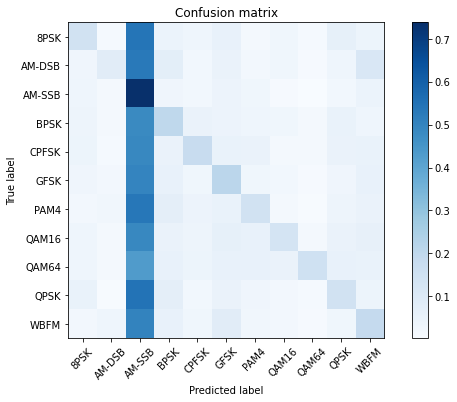

<Figure size 432x288 with 0 Axes>

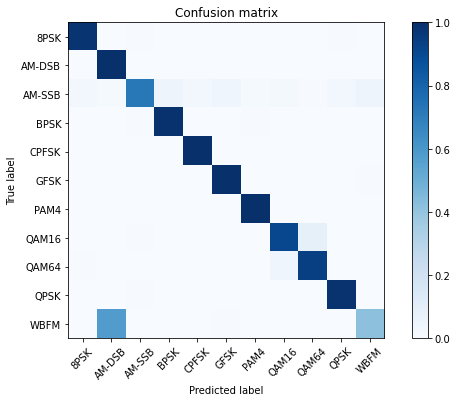

In [11]:
acc_proposal = np.zeros(len(test_snrs))
for s in range(20):

#     extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = samples_db[s]
    test_Y_i = truth_labels_db[s]
    
    # estimate classes
    test_Y_i_hat = model_proposal.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #print the confusion matrix @ -20dB and 20dB
    if s == 0 or s == 19:
        plt.figure()
        plot_confusion_matrix(confnorm, labels=classes)
           
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc_proposal[s] = 1.0*cor/(cor+ncor)